основной целью работы является совместное использование batch normalization and weight decay в нейронных сетях для разных датасетов. По словам авторов это приводит к периодическому поведению динамики оптимизации.

попробуем провести эксперимент на датасете cifar-10, но напишем свою нейронку

In [3]:
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

In [8]:
# конфигурация модели
batch_size = 50
img_width, img_height, img_num_channels = 32, 32, 3
loss_function = sparse_categorical_crossentropy
no_classes = 10
no_epochs = 10
optimizer = Adam()
validation_split = 0.2
verbosity = 1

In [9]:
# загрузим CIFAR-10 
(input_train, target_train), (input_test, target_test) = cifar10.load_data()

input_shape = (img_width, img_height, img_num_channels)

input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# нормализация
input_train = input_train / 255
input_test = input_test / 255

In [14]:
# создание модели
from tensorflow.keras.regularizers import l2
weight_decay = 1e-4
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu',kernel_regularizer=l2(weight_decay)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(no_classes, activation='softmax'))

In [15]:
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])

history = model.fit(input_train, target_train,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_split=validation_split)



Epoch 1/10
800/800 [==============================] - 65s 80ms/step - loss: 1.8940 - accuracy: 0.2723 - val_loss: 1.6339 - val_accuracy: 0.3891
Epoch 2/10
800/800 [==============================] - 67s 84ms/step - loss: 1.5338 - accuracy: 0.4357 - val_loss: 1.4522 - val_accuracy: 0.4613
Epoch 3/10
800/800 [==============================] - 62s 78ms/step - loss: 1.3881 - accuracy: 0.4932 - val_loss: 1.3573 - val_accuracy: 0.5054
Epoch 4/10
800/800 [==============================] - 64s 79ms/step - loss: 1.3058 - accuracy: 0.5282 - val_loss: 1.3083 - val_accuracy: 0.5296
Epoch 5/10
800/800 [==============================] - 63s 78ms/step - loss: 1.2468 - accuracy: 0.5544 - val_loss: 1.2568 - val_accuracy: 0.5486
Epoch 6/10
800/800 [==============================] - 62s 78ms/step - loss: 1.2056 - accuracy: 0.5695 - val_loss: 1.2147 - val_accuracy: 0.5650
Epoch 7/10
800/800 [==============================] - 63s 78ms/step - loss: 1.1614 - accuracy: 0.5850 - val_loss: 1.1864 - val_accuracy:

В качестве метода оптимизации использовался обычный SGD. Learning rate не изменялся на протяжении тренировки. Никакой аугментации к данным не применялось, т.е. и для тренировки и для тестирования брались полные картинки 32 на 32 пикселя. Использовалась L2 регуляризация с weight decay = 0.0001

Ошибка и точность на тренировочном датасете считается на протяжении эпохи по каждому батчу и в конце каждой эпохи усредняется и записывается.

Test loss: 1.1453351974487305 / Test accuracy: 0.5960999727249146


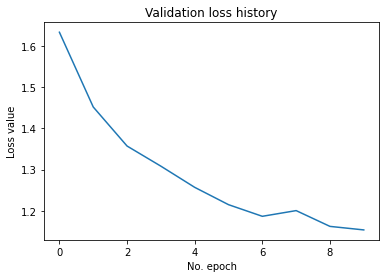

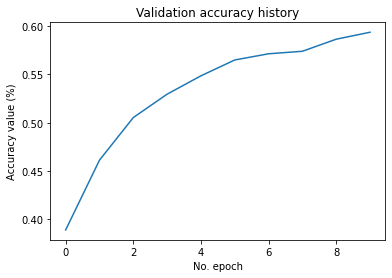

In [16]:
score = model.evaluate(input_test, target_test, verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

plt.plot(history.history['val_loss'])
plt.title('Validation loss history')
plt.ylabel('Loss value')
plt.xlabel('No. epoch')
plt.show()

plt.plot(history.history['val_accuracy'])
plt.title('Validation accuracy history')
plt.ylabel('Accuracy value (%)')
plt.xlabel('No. epoch')
plt.show()

Выводы.

При неизменных остальных параметрах тренировки, сеть с применением batch normalization сходится быстрее. Причем сходится даже при таком learning rate, при котором сеть без batch normalization не сходится.